<a href="https://colab.research.google.com/github/cindymustika/Capstone-Project/blob/main/sorof_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preprocessing**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the uploaded dataset to inspect its structure
import pandas as pd

# Path ke file dalam Google Drive
file_path = '/content/drive/MyDrive/Capstone_Project /arabic_verb_forms.csv'

# Baca file CSV
data = pd.read_csv(file_path)
print(data.head())

   ID Unvocalized    Vocalized Root Normalized  Triliteral  Past  Future  \
0   1        أمكن      أمْكَنَ  مكن       ءمكن           0     0       0   
1   2      استحال  اِسْتَحَالَ  حيل     استحال           0     0       0   
2   3         زها        زَهَا  زهو        زها           1     0       0   
3   4         بئس       بِئْسَ  بأس        بءس           1     0       0   
4   5        أغمى      أَغْمَى  غمي       ءغمى           0     0       0   

   Imperative  Passive Madhi Mudhari  Amar Madhi_from_Vocalized  \
0           0        0   مكن    يمكن  امكن              أمْكَنَ   
1           0        0   حال    يحال  احال          اِسْتَحَالَ   
2           0        1   زها    يزها  ازها                زَهَا   
3           0        0   بئس    يبئس  ابئس               بِئْسَ   
4           0        1   غمى    يغمى  اغمى              أَغْمَى   

  Mudhari_from_Vocalized Amar_from_Vocalized  
0                   يمكن                امكن  
1                   يحال                احال  

In [4]:
# Display the first few rows of the dataset to understand its structure
data.head()

# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())

# Ensure the data is in the correct format
print("\nData types of each column:")
print(data.dtypes)

# Display the first few rows of the updated DataFrame
print("\nFirst few rows of the DataFrame:")
print(data.head())

Missing values in each column:
ID                        0
Unvocalized               0
Vocalized                 0
Root                      0
Normalized                0
Triliteral                0
Past                      0
Future                    0
Imperative                0
Passive                   0
Madhi                     0
Mudhari                   0
Amar                      0
Madhi_from_Vocalized      0
Mudhari_from_Vocalized    0
Amar_from_Vocalized       0
dtype: int64

Data types of each column:
ID                         int64
Unvocalized               object
Vocalized                 object
Root                      object
Normalized                object
Triliteral                 int64
Past                       int64
Future                     int64
Imperative                 int64
Passive                    int64
Madhi                     object
Mudhari                   object
Amar                      object
Madhi_from_Vocalized      object
Mudhari_from_Vocal

**Model Architecture and Training**

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Capstone_Project /arabic_verb_forms.csv')

# Select relevant columns
input_column = 'Unvocalized'
output_columns = ['Madhi', 'Mudhari', 'Amar']

# Drop rows with missing values
data = data.dropna(subset=[input_column] + output_columns)

# Simplify rare classes by grouping them into 'Other'
threshold = 3
for col in output_columns:
    value_counts = data[col].value_counts()
    rare_classes = value_counts[value_counts < threshold].index
    data[col] = data[col].apply(lambda x: 'Other' if x in rare_classes else x)

# Tokenizer setup
max_vocab_size = 3000
max_sequence_length = 6
tokenizer = Tokenizer(num_words=max_vocab_size, char_level=True, oov_token='<UNK>')
tokenizer.fit_on_texts(data[input_column])

# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(data[input_column])
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

# Encode target columns
label_encoders = {}
y_encoded = {}
for col in output_columns:
    le = LabelEncoder()
    y_encoded[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Stack encoded target columns
y = np.stack([y_encoded[col] for col in output_columns], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model architecture
def create_model(max_vocab_size, max_sequence_length, output_dims):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(
        input_dim=max_vocab_size,
        output_dim=64,
        input_length=max_sequence_length,
        embeddings_regularizer=l2(1e-4)
    )(input_layer)
    norm_layer = BatchNormalization()(embedding_layer)
    lstm_layer = Bidirectional(LSTM(
        128,
        return_sequences=True,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4),
        bias_regularizer=l2(1e-4)
    ))(norm_layer)
    lstm_layer = Dropout(0.4)(lstm_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    lstm_layer = Bidirectional(LSTM(
        128,
        return_sequences=False,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4),
        bias_regularizer=l2(1e-4)
    ))(lstm_layer)
    lstm_layer = Dropout(0.4)(lstm_layer)
    dense_layer = BatchNormalization()(lstm_layer)
    output_layers = []
    for i, dim in enumerate(output_dims):
        output = Dense(
            dim,
            activation='softmax',
            name=output_columns[i],
            kernel_regularizer=l2(1e-4)
        )(dense_layer)
        output_layers.append(output)
    return Model(inputs=input_layer, outputs=output_layers)

# Number of classes for each output
output_dims = [len(label_encoders[col].classes_) for col in output_columns]

# Create and compile model
model = create_model(max_vocab_size, max_sequence_length, output_dims)
model.compile(
    optimizer=Adam(learning_rate=5e-4),
    loss=['sparse_categorical_crossentropy'] * len(output_columns),
    metrics=['accuracy'] * len(output_columns)
)

#Display Model
model.summary()

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train,
    [y_train[:, i] for i in range(y_train.shape[1])],
    validation_data=(X_test, [y_test[:, i] for i in range(y_test.shape[1])]),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 6, 64)          │        192,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 6, 64)          │            256 │ embedding[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 6, 256)         │        197,632 │ batch_normalization[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 6, 256)         │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 6, 256)         │          1,024 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        394,240 │ batch_normalization_1… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256)            │          1,024 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Madhi (Dense)             │ (None, 1598)           │        410,686 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Mudhari (Dense)           │ (None, 1598)           │        410,686 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Amar (Dense)              │ (None, 1598)           │        410,686 │ batch_normalization_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,018,234 (7.70 MB)

 Trainable params: 2,017,082 (7.69 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - Amar_accuracy: 0.0860 - Amar_loss: 7.1731 - Madhi_accuracy: 0.0904 - Madhi_loss: 7.1633 - Mudhari_accuracy: 0.0920 - Mudhari_loss: 7.1563 - loss: 21.8012 - val_Amar_accuracy: 0.3811 - val_Amar_loss: 6.8961 - val_Madhi_accuracy: 0.3811 - val_Madhi_loss: 6.8986 - val_Mudhari_accuracy: 0.3825 - val_Mudhari_loss: 6.8759 - val_loss: 20.9473 - learning_rate: 5.0000e-04
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - Amar_accuracy: 0.2983 - Amar_loss: 5.8514 - Madhi_accuracy: 0.3014 - Madhi_loss: 5.8535 - Mudhari_accuracy: 0.3034 - Mudhari_loss: 5.8492 - loss: 17.8356 - val_Amar_accuracy: 0.3844 - val_Amar_loss: 5.3340 - val_Madhi_accuracy: 0.3844 - val_Madhi_loss: 5.3428 - val_Mudhari_accuracy: 0.3844 - val_Mudhari_loss: 5.3179 - val_loss: 16.2608 - learning_rate: 5.0000e-04
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - Amar_accuracy: 0.3744 - Amar_loss: 4.7257 - Madhi_accuracy: 0.3769 - Madhi_loss: 4.7233 - Mudhari_acc

**Evaluate the Model**

In [7]:
evaluation = model.evaluate(
    X_test, [y_test[:, i] for i in range(y_test.shape[1])], verbose=1
)

print("Evaluation Results:")
for col, index in zip(output_columns, [6, 5, 4]):  # Indeks untuk Madhi, Mudhari, Amar
    print(f"{col} Accuracy: {evaluation[index] * 100:.2f}%")



67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - Amar_accuracy: 0.9151 - Amar_loss: 0.5126 - Madhi_accuracy: 0.9132 - Madhi_loss: 0.5105 - Mudhari_accuracy: 0.9147 - Mudhari_loss: 0.5095 - loss: 2.1664
Evaluation Results:
Madhi Accuracy: 91.12%
Mudhari Accuracy: 90.98%
Amar Accuracy: 91.21%


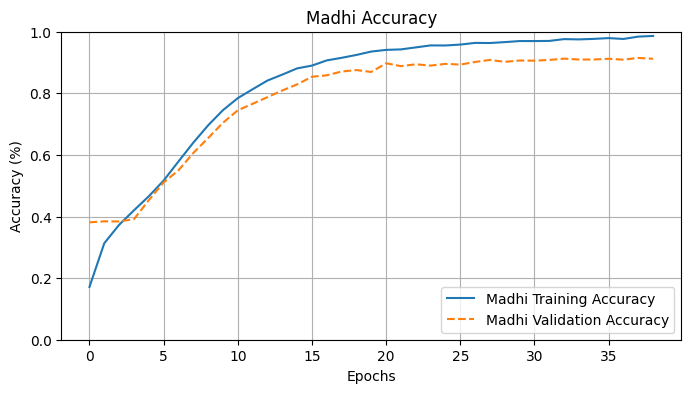

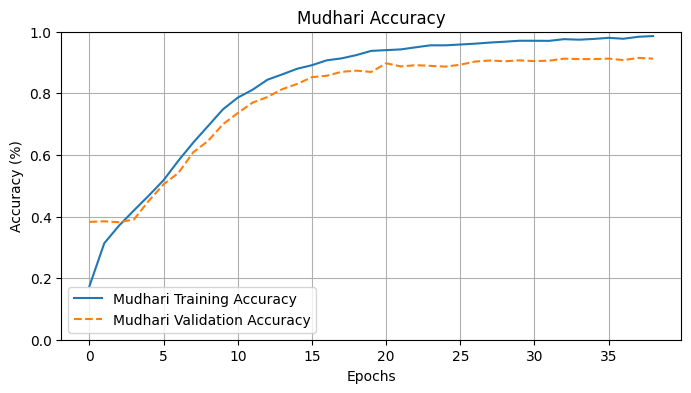

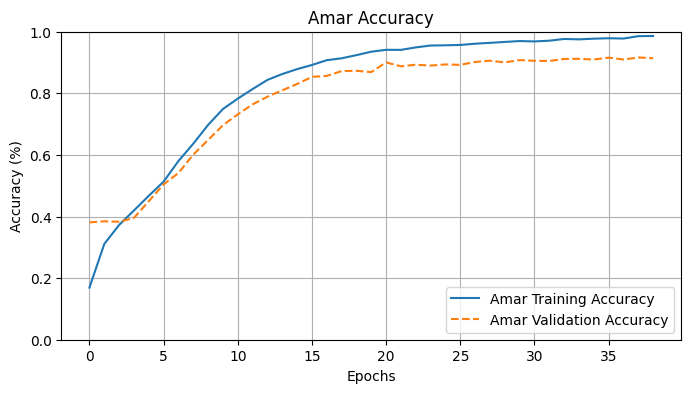

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for each output
def plot_training_accuracy(history, output_columns):
    for col in output_columns:
        plt.figure(figsize=(8, 4))
        # Plot training and validation accuracy
        plt.plot(history.history[f'{col}_accuracy'], label=f'{col} Training Accuracy')
        plt.plot(history.history[f'val_{col}_accuracy'], label=f'{col} Validation Accuracy', linestyle='--')
        plt.title(f'{col} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function to plot accuracy
plot_training_accuracy(history, output_columns)


**Save, Load, and Test Model**

In [9]:
# Save the trained model
model.save('arabic_verb_model.h5')
print("Model berhasil disimpan sebagai 'arabic_verb_model.h5'")

Model berhasil disimpan sebagai 'arabic_verb_model.h5'


In [10]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
print("Memuat model...")
model = load_model('arabic_verb_model.h5')
print("Model berhasil dimuat.")


while True:  # Loop untuk mengizinkan pengujian berulang kali
   a
    test_word = input("Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): ").strip()
    if test_word.lower() == 'exit':  # Keluar dari loop jika pengguna mengetik 'exit'
        print("Keluar dari pengujian.")
        break

    # Preprocessing: Tokenize dan pad input
    test_sequence = tokenizer.texts_to_sequences([test_word])
    test_sequence = pad_sequences(test_sequence, maxlen=max_sequence_length, padding='post')

    # Prediksi menggunakan model
    predictions = model.predict(test_sequence)

    # Decode hasil prediksi untuk setiap output
    decoded_outputs = {}
    for i, col in enumerate(output_columns):
        predicted_class = np.argmax(predictions[i], axis=-1)  # Ambil kelas dengan probabilitas tertinggi
        decoded_outputs[col] = label_encoders[col].inverse_transform([predicted_class[0]])[0]  # Dekode ke label asli

    # Tampilkan hasil prediksi
    print(f"\nHasil Prediksi untuk kata '{test_word}':")
    for col, result in decoded_outputs.items():
        print(f"{col}: {result}")
    print("-" * 30)  # Pemisah untuk setiap pengujian


Memuat model...
Model berhasil dimuat.
Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): كتب
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step

Hasil Prediksi untuk kata 'كتب':
Madhi: كتب
Mudhari: يكتب
Amar: اكتب
------------------------------
Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): ذهب
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Hasil Prediksi untuk kata 'ذهب':
Madhi: ذهب
Mudhari: يذهب
Amar: اذهب
------------------------------
Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): ركب
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Hasil Prediksi untuk kata 'ركب':
Madhi: ركب
Mudhari: يركب
Amar: اركب
------------------------------
Masukkan kata untuk pengujian (atau ketik 'exit' untuk keluar): exit
Keluar dari pengujian.
